In [48]:
import sys
import os
import json
import glob
import copy
import h5py
import time
import pdb
import functools
import multiprocessing
import numpy as np
import scipy.signal
import scipy.io.wavfile
%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd
import importlib

sys.path.append('/om2/user/msaddler/pitchnet/assets_psychophysics')
import f0dl_bernox
import util_figures_psychophysics

sys.path.append('/om2/user/msaddler/python-packages/bez2018model')
import bez2018model
importlib.reload(bez2018model)

sys.path.append('/om2/user/msaddler/python-packages/msutil')
import util_figures
importlib.reload(util_figures)
import util_stimuli
importlib.reload(util_stimuli)
import util_misc
importlib.reload(util_misc)

save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2020_09_26_pitchnet_paper_figures_v03/'


In [2]:
def adaptive_threshold_measurement(f0,
                                   t,
                                   sr=100e3,
                                   dBSPL_max=100.0,
                                   dBSPL_step=2.5,
                                   kwargs_nervegram={}):
    '''
    '''
    dBSPL = dBSPL_max
    list_meanrate = []
    list_dBSPL = []
    while True:
        y = np.sin(2 * np.pi * f0 * t + (np.pi/2 * np.random.rand()))
        y = util_stimuli.set_dBSPL(y, dBSPL)
        out_dict = bez2018model.nervegram(y, sr, **kwargs_nervegram)
        list_meanrate.append(np.mean(np.squeeze(out_dict['nervegram_meanrates'])))
        list_dBSPL.append(dBSPL)
        if list_meanrate[-1] > kwargs_nervegram.get('spont', 70.0) * 1.1:
            dBSPL -= dBSPL_step
        else:
            break
    return dBSPL


def get_ANF_tuning(cf,
                   kwargs_nervegram_update={},
                   list_f0=np.exp(np.linspace(np.log(1e2), np.log(1e4), 200)),
                   max_processes=60,
                   sr=100e3,
                   dBSPL_max=100.0,
                   dBSPL_step=2.5):
    '''
    '''
    kwargs_nervegram = {
        'nervegram_dur': 0.050,
        'nervegram_fs': 20e3,
        'buffer_start_dur': 0.070,
        'buffer_end_dur': 0.010,
        'pin_fs': 100e3,
        'pin_dBSPL_flag': 0,
        'pin_dBSPL': None,
        'species': 2,
        'bandwidth_scale_factor': 1.0,
        'cf_list': None,
        'num_cf': 1,
        'min_cf': cf,
        'max_cf': cf,
        'max_spikes_per_train': 500,
        'num_spike_trains': 1,
        'cohc': 1.0,
        'cihc': 1.0,
        'IhcLowPass_cutoff': 3000,
        'IhcLowPass_order': 7,
        'spont': 70.0,
        'noiseType': 0,
        'implnt': 0,
        'tabs': 6e-4,
        'trel': 6e-4,
        'random_seed': None,
        'return_vihcs': False,
        'return_meanrates': True,
        'return_spike_times': False,
        'return_spike_tensor_sparse': False,
        'return_spike_tensor_dense': False,
        'nervegram_spike_tensor_fs': 100e3,
    }
    kwargs_nervegram.update(kwargs_nervegram_update)
    
    dur = kwargs_nervegram['nervegram_dur']
    dur += kwargs_nervegram['buffer_start_dur']
    dur += kwargs_nervegram['buffer_end_dur']
    t = np.arange(0, dur, 1/sr)
    
    parallel_wrapper = functools.partial(
        adaptive_threshold_measurement,
        t,
        sr=sr,
        dBSPL_max=dBSPL_max,
        dBSPL_step=dBSPL_step,
        kwargs_nervegram=kwargs_nervegram,
    )
    
    with multiprocessing.Pool(processes=np.min([len(list_f0), max_processes])) as pool:
        list_thresholds = pool.map(parallel_wrapper, list_f0)
    
    return list_f0, list_thresholds


dict_kwargs_nervegram_update = {
    'ohc_loss': {'cohc': 0.0},
    'ohc_loss_partial': {'cohc': 0.2},
    'human': {'bandwidth_scale_factor': 1.0},
    'narrow': {'bandwidth_scale_factor': 0.5},
    'broad': {'bandwidth_scale_factor': 2.0},
    'linear': {'bandwidth_scale_factor': 80.0, 'species': 4},
}
dict_results = {}

list_cf = [250.0, 5e2, 1e3, 2e3, 4e3]

for key in sorted(dict_kwargs_nervegram_update.keys()):
    dict_results[key] = []
    t0 = time.time()
    for cf in list_cf:
        list_f0, list_thresholds = get_ANF_tuning(
            cf=cf,
            kwargs_nervegram_update=dict_kwargs_nervegram_update[key])
        dict_results[key].append(list_thresholds)
    print(key, time.time() - t0)


broad 16.112001657485962
human 13.845239639282227
linear 12.764536142349243
narrow 12.298098802566528
ohc_loss 11.103330612182617
ohc_loss_partial 12.152795553207397


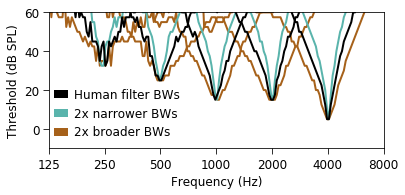

In [6]:
fig, ax = plt.subplots(figsize=(6, 2.5))

dict_kwargs_plot = {
#     'ohc_loss': {'c': 'r', 'label': 'cohc=0.0', 'lw': 2},
#     'ohc_loss_partial': {'c': 'b', 'label': 'cohc=0.2', 'lw': 2},
#     'human': {'c': 'k', 'label': 'cohc=1.0', 'zorder': 1, 'lw': 2},

    'narrow': {'c': '#5ab4ac', 'label': '2x narrower BWs', 'zorder': 0, 'lw': 2},
    'human': {'c': 'k', 'label': 'Human filter BWs', 'zorder': 1, 'lw': 2},
    'broad': {'c': '#a6611a', 'label': '2x broader BWs', 'zorder': -1, 'lw': 2},
    'linear': {'c': '#f768a1', 'label': 'Linearly spaced', 'lw': 2},
}

list_keys_to_plot = [
    'human',
    'narrow',
    'broad',
    
#     'human',
#     'linear',
    
#     'human',
#     'ohc_loss',
#     'ohc_loss_partial',
]

for key in list_keys_to_plot:
    for itr0, list_thresholds in enumerate(dict_results[key]):
        if itr0 > 0:
            dict_kwargs_plot[key]['label'] = None
        ax.plot(list_f0, list_thresholds, **dict_kwargs_plot[key])
#         print(key, np.min(list_thresholds))

xticks = [list_cf[0]/2] + list_cf + [list_cf[-1]*2]
if 'ohc_loss' in list_keys_to_plot:
    ylimits = [-10, 90]
else:
    ylimits = [-10, 60]
ax = util_figures.format_axes(
    ax,
    xscale='log',
    str_xlabel='Frequency (Hz)',
    str_ylabel='Threshold (dB SPL)',
    str_title=None,
    xticks=xticks,
    xticklabels=np.array(xticks).astype(int),
    xticks_minor=[],
    xlimits=[xticks[0], xticks[-1]],
    ylimits=ylimits)
legend_plot_kwargs = {
    'loc': 'lower left',
    'ncol': 1,
    'borderpad': 0.4,
    'borderaxespad': 0.4,
    'handletextpad': 0.8,
    'frameon': False,
    'handlelength': 0.5,
    'markerscale': 1.0,
    'fontsize': 12,
}
leg = ax.legend(**legend_plot_kwargs)
for legobj in leg.legendHandles:
    legobj.set_linewidth(8.0)

plt.show()

fig.savefig('tmp.pdf', bbox_inches='tight', pad_inches=0, transparent=False)


84.44678253431881 85.34073128172602


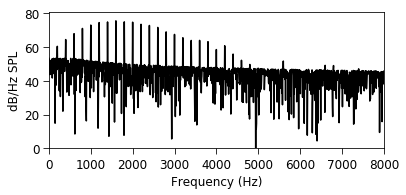

In [134]:
sys.path.append('assets_datasets/')
import stimuli_generate_BernsteinOxenhamFixedFilter


random_seed = 858
np.random.seed(random_seed)
sr = 32000
dur = 0.150
f0 = 200
lh = 1
phase_mode = 'sine'

INCREASE_DBSPL = 27

threshold_dBSPL = 33.3 + INCREASE_DBSPL
component_dBSL = 15.0
highpass_filter_cutoff = 2.5e3
lowpass_filter_cutoff = 3.5e3
filter_order = 4
noise_dBHzSPL = 15.0 + INCREASE_DBSPL
noise_attenuation_start = 600.0
noise_attenuation_slope = 2.0
strict_audible_harm = False

baseline_freq_response = stimuli_generate_BernsteinOxenhamFixedFilter.get_bandpass_filter_frequency_response(
    highpass_filter_cutoff,
    lowpass_filter_cutoff,
    fs=sr,
    order=filter_order)
desired_fl = f0 * lh
desired_fl_gain_in_dB = -1 * component_dBSL
fixed_freq_response = stimuli_generate_BernsteinOxenhamFixedFilter.shift_bandpass_filter_frequency_response(
    desired_fl,
    desired_fl_gain_in_dB,
    fs=sr,
    unshifted_passband=None,
    frequency_response_in_dB=baseline_freq_response)
signal, audible_harmonic_numbers = stimuli_generate_BernsteinOxenhamFixedFilter.bernox2005_bandpass_complex_tone(
    f0,
    sr,
    dur,
    frequency_response_in_dB=fixed_freq_response,
    threshold_dBSPL=threshold_dBSPL,
    component_dBSL=component_dBSL,
    strict_low_harm=None,
    strict_audible_harm=strict_audible_harm,
    phase_mode=phase_mode)
noise = util_stimuli.modified_uniform_masking_noise(
    sr,
    dur,
    dBHzSPL=noise_dBHzSPL,
    attenuation_start=noise_attenuation_start,
    attenuation_slope=noise_attenuation_slope)

y = signal + noise
print(util_stimuli.get_dBSPL(signal), util_stimuli.get_dBSPL(y))
# signal = util_stimuli.set_dBSPL(signal, 60.0)
# y = util_stimuli.combine_signal_and_noise(signal, noise, np.inf)

fxx, pxx = util_stimuli.power_spectrum(y, sr)

fig, ax = plt.subplots(figsize=(6, 2.5))
ax.plot(fxx, pxx, 'k-')
ax = util_figures.format_axes(
    ax,
    str_xlabel='Frequency (Hz)',
    str_ylabel='dB/Hz SPL',
    str_title=None,
    xlimits=[0, sr/4],
    ylimits=[0, None])
plt.show()

ipd.display(ipd.Audio(y, rate=sr))



In [28]:
random_seed = 858
np.random.seed(random_seed)
kwargs_nervegram = {
    'nervegram_dur': 0.050,
    'nervegram_fs': 20000,
    'buffer_start_dur': 0.070,
    'buffer_end_dur': 0.010,
    'pin_fs': 100e3,
    'pin_dBSPL_flag': 0,
    'pin_dBSPL': None,
    'species': 2,
    'bandwidth_scale_factor': 1.0,
    'cf_list': None,
    'num_cf': 100,
    'min_cf': 125.0,
    'max_cf': 14e3,
    'max_spikes_per_train': 500,
    'num_spike_trains': 1,
    'cohc': 0.1,
    'cihc': 1.0,
    'IhcLowPass_cutoff': 3000.0,
    'IhcLowPass_order': 7,
    'spont': 70.0,
    'noiseType': 0,
    'implnt': 0,
    'tabs': 6e-4,
    'trel': 6e-4,
    'random_seed': None,
    'return_vihcs': False,
    'return_meanrates': True,
    'return_spike_times': False,
}
out_dict = bez2018model.nervegram(y, sr, **kwargs_nervegram)
out_dict['nervegram_meanrates'].shape


(100, 1000)

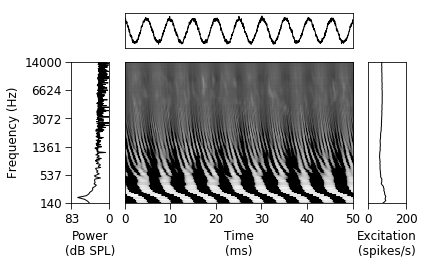

In [29]:
figsize=(6, 3.5)
nrows=2
ncols=3
gridspec_kw = {
    'wspace': 0.15,
    'hspace': 0.15,
    'width_ratios': [1, 6, 1],
    'height_ratios': [1, 4],
}
fig, ax_arr = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, gridspec_kw=gridspec_kw)
nervegram = np.squeeze(out_dict['nervegram_meanrates']).copy()
util_figures.make_stimulus_summary_plot(
    ax_arr,
    ax_idx_waveform=1,
    ax_idx_spectrum=3,
    ax_idx_nervegram=4,
    ax_idx_excitation=5,
    waveform=out_dict['signal'],
    nervegram=nervegram,
    sr_waveform=out_dict['signal_fs'],
    sr_nervegram=out_dict['nervegram_fs'],
    cfs=out_dict['cf_list'],
    tmin=None,
    tmax=None,
    treset=True,
    vmin=None,
    vmax=None,
    erb_freq_axis=True,
    spines_to_hide_waveform=[],
    spines_to_hide_spectrum=[],
    spines_to_hide_excitation=[],
    nxticks=6,
    nyticks=6,
    kwargs_plot={},
    limits_buffer=0.2,
    ax_arr_clear_leftover=True)

xticks = [0, 200]
ax_arr[1,2].set_xlim(xticks)
ax_arr[1,2].set_xticks(xticks)
ax_arr[1,2].set_xticklabels(xticks)

plt.show()


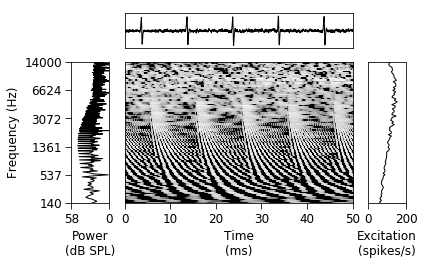

In [72]:
figsize=(6, 3.5)
nrows=2
ncols=3
gridspec_kw = {
    'wspace': 0.15,
    'hspace': 0.15,
    'width_ratios': [1, 6, 1],
    'height_ratios': [1, 4],
}
fig, ax_arr = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, gridspec_kw=gridspec_kw)
nervegram = np.squeeze(out_dict['nervegram_meanrates']).copy()
util_figures.make_stimulus_summary_plot(
    ax_arr,
    ax_idx_waveform=1,
    ax_idx_spectrum=3,
    ax_idx_nervegram=4,
    ax_idx_excitation=5,
    waveform=out_dict['signal'],
    nervegram=nervegram,
    sr_waveform=out_dict['signal_fs'],
    sr_nervegram=out_dict['nervegram_fs'],
    cfs=out_dict['cf_list'],
    tmin=None,
    tmax=None,
    treset=True,
    vmin=None,
    vmax=None,
    erb_freq_axis=True,
    spines_to_hide_waveform=[],
    spines_to_hide_spectrum=[],
    spines_to_hide_excitation=[],
    nxticks=6,
    nyticks=6,
    kwargs_plot={},
    limits_buffer=0.2,
    ax_arr_clear_leftover=True)

xticks = [0, 200]
ax_arr[1,2].set_xlim(xticks)
ax_arr[1,2].set_xticks(xticks)
ax_arr[1,2].set_xticklabels(xticks)

plt.show()


In [202]:
sys.path.append('assets_datasets/')
import stimuli_generate_TransposedTones
import stimuli_generate_FrequencyShiftedComplexes
import stimuli_generate_MistunedHarmonics
import stimuli_generate_AltPhaseHarmonics

# hdf5_filename = '/om/user/msaddler/data_pitchnet/oxenham2004/transposedtones_v01_dbspl85/stim.hdf5'
# stimuli_generate_TransposedTones.generate_Oxenham2004_dataset(
#     hdf5_filename,
#     fs=32000,
#     dur=0.150,
#     buffer_dur=1.0,
#     dBSPL=85.0,
#     offset_start=True,
#     lowpass_filter_envelope=True,
#     list_f_carrier=[0.0, 4000.0, 6350.0, 10080.0],
#     f0_min=80.0,
#     f0_max=320.,
#     step_size_in_octaves=1/(12*16*16),
#     noise_params={'dBHzSPL':15.0, 'attenuation_start':600.0, 'attenuation_slope':2.0},
#     disp_step=100)

# hdf5_filename = '/om/user/msaddler/data_pitchnet/mooremoore2003/freqshifted_v01_dbspl85/stim.hdf5'
# stimuli_generate_FrequencyShiftedComplexes.generate_MooreMoore2003_dataset(
#     hdf5_filename,
#     noise_params={},
#     dBSPL=85.0)

# hdf5_filename = '/om/user/msaddler/data_pitchnet/moore1985/mistunedharm_v01_dbspl85/stim.hdf5'
# stimuli_generate_MistunedHarmonics.generate_MistunedHarmonics_dataset(
#     hdf5_filename,
#     fs=32000,
#     dur=0.150,
#     f0_ref_list=[100.0, 200.0, 400.0],
#     f0_ref_width=0.04,
#     step_size_in_octaves=1/(192*8),
#     phase_mode='sine', 
#     low_harm=1,
#     upp_harm=12,
#     harmonic_dBSPL=75.0,
#     list_mistuned_pct=[-8, -6, -4, -3, -2, -1, 0, 1, 2, 3, 4, 6, 8],
#     list_mistuned_harm=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
#     noise_params={},
#     disp_step=100)

# hdf5_filename = '/om/user/msaddler/data_pitchnet/shackcarl1994/altphase_v01_dbspl85/stim.hdf5'
# stimuli_generate_AltPhaseHarmonics.generate_AltPhase_dataset(
#     hdf5_filename,
#     fs=32000,
#     dur=0.150,
#     phase_modes=['alt', 'sine'],
#     f0_min=80.0,
#     f0_max=320.0,
#     step_size_in_octaves=1/(192*16),
#     include_2xF0=False,
#     filter_order=8,
#     passband_component_dBSPL=50.0+27,
#     noise_dBHzSPL=15.0+27,
#     noise_attenuation_start=600.0,
#     noise_attenuation_slope=2,
#     disp_step=1000)


f_carrier = 0 --> generating pure tone at f_envelope
[INITIALIZING]: /om/user/msaddler/data_pitchnet/oxenham2004/transposedtones_v01_dbspl85/stim.hdf5
... signal 0 of 24576
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pur

f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_en

f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_en

f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
... signal 500 of 24576
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> gene

f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_en

f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_en

f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
... signal 1000 of 24576
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> gen

f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_en

f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_en

f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
... signal 1500 of 24576
f_carrier = 0 --> gen

f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_en

f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_en

f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
... signal 2000 of 24576
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> gen

f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_en

f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_en

f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
... signal 2500 of 24576
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> gen

f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_en

f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_en

f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
... signal 3000 of 24576
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> gen

f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_en

f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_en

f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
... signal 3500 of 24576
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> gen

f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_en

f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_en

f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_en

f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_en

f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_en

f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_en

f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_en

f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_en

f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
... signal 5000 of 24576
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> gen

f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_en

f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_en

f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_en

f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_en

f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_en

f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
... signal 6000 of 24576
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> generating pure tone at f_envelope
f_carrier = 0 --> gen

... signal 6800 of 24576
... signal 6900 of 24576
... signal 7000 of 24576
... signal 7100 of 24576
... signal 7200 of 24576
... signal 7300 of 24576
... signal 7400 of 24576
... signal 7500 of 24576
... signal 7600 of 24576
... signal 7700 of 24576
... signal 7800 of 24576
... signal 7900 of 24576
... signal 8000 of 24576
... signal 8100 of 24576
... signal 8200 of 24576
... signal 8300 of 24576
... signal 8400 of 24576
... signal 8500 of 24576
... signal 8600 of 24576
... signal 8700 of 24576
... signal 8800 of 24576
... signal 8900 of 24576
... signal 9000 of 24576
... signal 9100 of 24576
... signal 9200 of 24576
... signal 9300 of 24576
... signal 9400 of 24576
... signal 9500 of 24576
... signal 9600 of 24576
... signal 9700 of 24576
... signal 9800 of 24576
... signal 9900 of 24576
... signal 10000 of 24576
... signal 10100 of 24576
... signal 10200 of 24576
... signal 10300 of 24576
... signal 10400 of 24576
... signal 10500 of 24576
... signal 10600 of 24576
... signal 10700 o

9.25
51.22532781948002


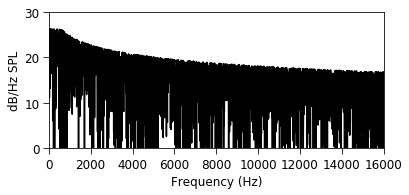

In [9]:
with h5py.File('/om/user/msaddler/data_pitchnet/bernox2005/puretone_v00/stim.hdf5', 'r') as f:
#     for v in f['stimuli'].values():
#         print(v)
    IDX = 1000
    y = f['tone_in_noise'][IDX]    
    print(f['dbspl'][IDX])

sr = 32e3
fxx, pxx = util_stimuli.power_spectrum(y, sr)

print(util_stimuli.get_dBSPL(y))
fig, ax = plt.subplots(figsize=(6, 2.5))
ax.plot(fxx, pxx, 'k-')
ax = util_figures.format_axes(
    ax,
    str_xlabel='Frequency (Hz)',
    str_ylabel='dB/Hz SPL',
    str_title=None,
    xlimits=[0, sr/2],
    ylimits=[0, None])
plt.show()

ipd.display(ipd.Audio(y, rate=sr))


In [56]:
regex_dir_model = '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0???'
basename_eval = 'EVAL_SOFTMAX_cohc1_puretone_v00_bestckpt.json'

list_dir_model = glob.glob(regex_dir_model)

list_results_dict = []
for dir_model in list_dir_model:
    fn_eval = os.path.join(dir_model, basename_eval)
    print(fn_eval)
    expt_dict = f0dl_bernox.load_f0_expt_dict_from_json(fn_eval, metadata_key_list=['dbspl', 'f0'])
    
    results_dict = {}
    list_group_f0 = np.split(np.unique(expt_dict['f0']), 10)
    for group_f0 in list_group_f0:
        list_vector_max = []
        for f0 in group_f0:
            IDX = expt_dict['f0'] == f0
            vector_dbspl = expt_dict['dbspl'][IDX]
            array_softmax = expt_dict['f0_label:probs_out'][IDX]
            SORT_IDX = np.argsort(vector_dbspl)
            vector_dbspl = vector_dbspl[SORT_IDX]
            array_softmax = array_softmax[SORT_IDX]
            vector_max = np.max(array_softmax, axis=1)
            list_vector_max.append(vector_max)
        mean_vector_max = np.mean(list_vector_max, axis=0)
        label = '{:04.0f}-{:04.0f} Hz'.format(group_f0[0], group_f0[-1])
        results_dict[label] = mean_vector_max
    
    list_results_dict.append(results_dict)



/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0083/EVAL_SOFTMAX_cohc1_puretone_v00_bestckpt.json
Loading f0_label_prob from /saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0083/EVAL_SOFTMAX_cohc1_puretone_v00_bestckpt_f0_label_probs_out.npy
Loaded f0_label_prob from /saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0083/EVAL_SOFTMAX_cohc1_puretone_v00_bestckpt_f0_label_probs_out.npy
/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0154/EVAL_SOFTMAX_cohc1_puretone_v00_bestckpt.json
Loading f0_label_prob from /saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0154/EVAL_SOFTMAX_cohc1_puretone_v00_bestckpt_f0_label_probs_out.npy
Loaded f0_label_prob from /saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN

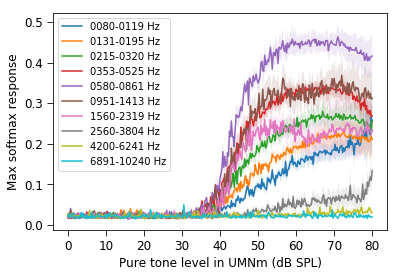

In [59]:
fig, ax = plt.subplots()

for itr0, key in enumerate(sorted(list_results_dict[0].keys())):
    subject_data = np.array([rd[key] for rd in list_results_dict])
    yval, yerr = util_figures_psychophysics.combine_subjects(subject_data, kwargs_bootstrap={})
    xval = vector_dbspl
    
    plot_kwargs = {
        'label': key,
        'color': util_figures.get_color_list(10, cmap_name='tab10')[itr0]
    }
    
    ax.fill_between(xval,
                    yval-2*yerr,
                    yval+2*yerr,
                    alpha=0.15,
                    facecolor=plot_kwargs['color'])
    ax.plot(xval, yval, **plot_kwargs)

ax.legend()
ax = util_figures.format_axes(
    ax,
    str_xlabel='Pure tone level in UMNm (dB SPL)',
    str_ylabel='Max softmax response',
    str_title=None)
plt.show()
